# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Uploading Data to Co Lab

In [41]:
## Mouting zip file from google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## Unzipping the file

from zipfile import ZipFile
filename = '/content/drive/My Drive/ieee-fraud-detection.zip'

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("Done")

Done


## Part 1 - Fraudulent vs Non-Fraudulent Transaction

Loading data as dataframe from the csv files and merging the identity and transaction files.

In [13]:
import pandas as pd


train_identity = pd.read_csv("train_identity.csv")
test_identity = pd.read_csv("test_identity.csv")
train_transaction = pd.read_csv("train_transaction.csv")
test_transaction = pd.read_csv("test_transaction.csv")

print(train_identity.shape)
print(test_identity.shape)

print(train_transaction.shape)
print(test_transaction.shape)

train_data = train_transaction.merge( train_identity, on='TransactionID', how='left')
test_data = test_transaction.merge(test_identity, on='TransactionID', how='left')

print(train_data.shape)
print(test_data.shape)


(144233, 41)
(141907, 41)
(590540, 394)
(506691, 393)
(590540, 434)
(506691, 433)


In [14]:
## Garbage collection

import gc
del test_identity, test_transaction
del train_identity, train_transaction
gc.collect()

146

0    569877
1     20663
Name: isFraud, dtype: int64


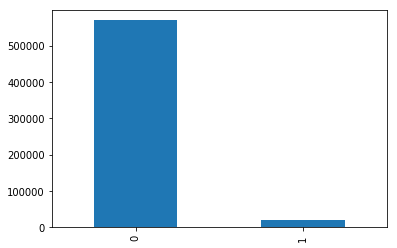

In [8]:
print(train_data.isFraud.value_counts())
train_data.isFraud.value_counts().plot('bar')

The above graph shows counts of fraudulent and non-fraudulent transactions. 

**Filtering fraudulent and non-fraudulent transactions**

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_data['Transaction_day_of_week'] = np.floor((train_data['TransactionDT'] / (3600 * 24) - 1) % 7)
train_data['Transaction_hour'] = np.floor(train_data['TransactionDT'] / 3600) % 24
train_data["TransactionAmt_log"] = np.log10(train_data.TransactionAmt) 

fraudulent_transactions = train_data[train_data["isFraud"]==1]
nonfraudulent_transactions = train_data[train_data["isFraud"]==0]

In [0]:

def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    total = len(df)
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    total_amt = train_data["TransactionAmt"].sum()
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()

**isFraud** vs **DeviceType**


Text(0, 0.5, 'Count')

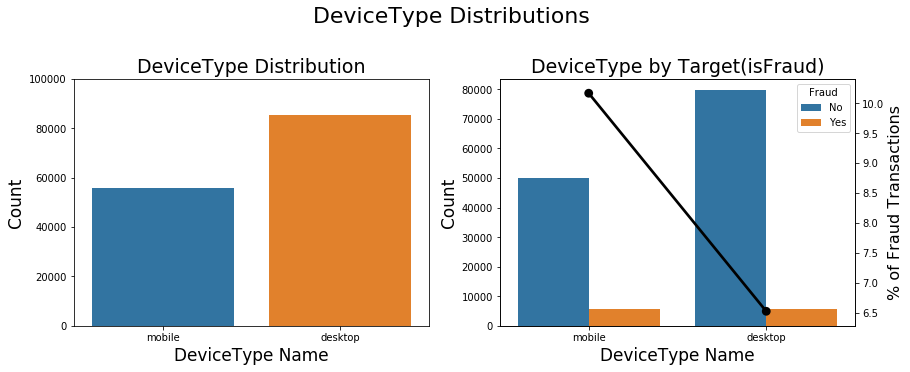

In [11]:
tmp = pd.crosstab(train_data['DeviceType'], train_data['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('DeviceType Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='DeviceType', data=train_data)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("DeviceType Distribution", fontsize=19)
g.set_xlabel("DeviceType Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,100000)
    
plt.subplot(222)
g1 = sns.countplot(x='DeviceType', hue='isFraud', data=train_data)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='DeviceType', y='Fraud', data=tmp, color='black', order=['mobile', 'desktop'], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("DeviceType by Target(isFraud)", fontsize=19)
g1.set_xlabel("DeviceType Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

The above distribution shows that the mobiles are more prone to fraudelent transactions as compared to desktop. In DeviceType by target distribution, the graph shows that about 10% of transactions done through mobiles are fraudulent while fraudulent transactions done through desktop is about 6.5%

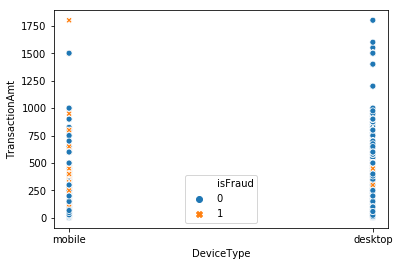

In [48]:
ax = sns.scatterplot(x="DeviceType", y="TransactionAmt", hue="isFraud", style="isFraud", data=train_data)

**isFraud** vs **TransactionDT**

The distribution of transaction hours shows that the waking hours of the people of time zone varies from 0-5 hours and 15-23 hours of a day. And the no. of fraudulent transactions increases in the 6-10 hours of a day. Thus, it can be inferred that fraudulent transactions are more prone to happen during non-waking hours of a day.


---
For transaction day of week, most of transactions tend to happen on the starting day of a week, i.e., Monday, and the starting day of a week is also most prone to fraudulent transactions.




Text(0.5, 1.0, 'Transaction_day_of_week Distribution')

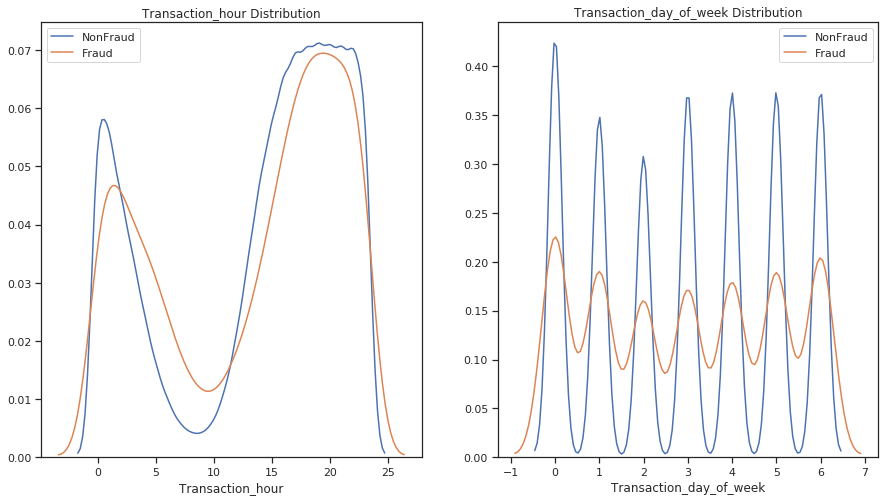

In [48]:
fig,ax=plt.subplots(1,2,figsize=(15,8))
sns.distplot(nonfraudulent_transactions['Transaction_hour'],ax=ax[0],hist=False,label='NonFraud')
sns.distplot(fraudulent_transactions['Transaction_hour'],ax=ax[0],hist=False,label='Fraud')
ax[0].set_title('Transaction_hour Distribution')


sns.distplot(nonfraudulent_transactions['Transaction_day_of_week'],ax=ax[1],hist=False,label='NonFraud')
sns.distplot(fraudulent_transactions['Transaction_day_of_week'],ax=ax[1],hist=False,label='Fraud')
ax[1].set_title('Transaction_day_of_week Distribution')

**isFraud** vs **TransactionAmt**


The box plot below suggests that more expensive transactions are more likely to be fraudulent. This can be inferred from the fact that the mean value of the red box is greater than that of the green box. Although the first quartiles of the two distributions are very similar, the third quartile of the red box is significantly greater than that of the green box, providing further evidence that higher transaction amounts are more likely to be fraudulent than not, i.e. the greater the transaction amount, the more likely it is for the transaction to be fraudulent.

This makes intuitive sense, because very expensive transactions have a greater chance of being fraudulent than less expensive transactions.



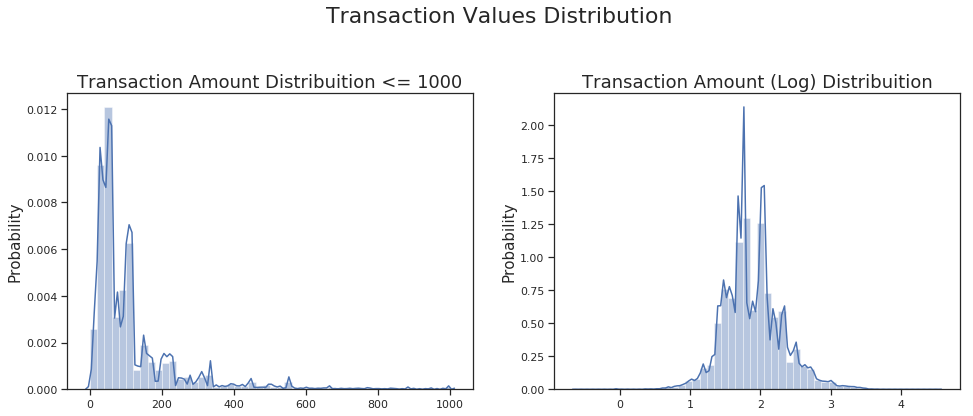

<Figure size 1152x864 with 0 Axes>

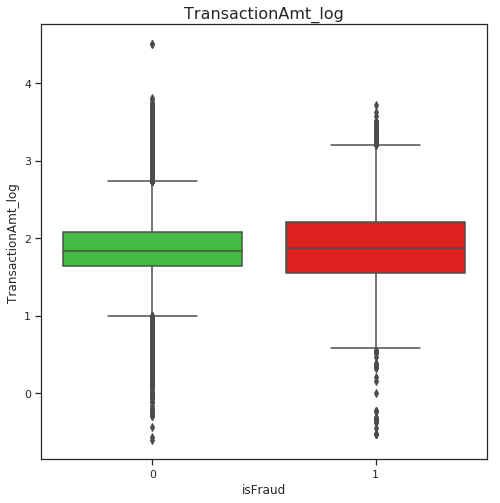

In [49]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(train_data[train_data['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(train_data['TransactionAmt_log'])
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


fig, ax = plt.subplots(figsize=(8, 8))
plot = sns.boxplot(x="isFraud", y="TransactionAmt_log", data=train_data, palette=["limegreen", "red"], ax=ax).set_title('TransactionAmt_log', fontsize=16)
plt.show()

**isFraud** vs **ProductCD**




Text(0, 0.5, 'Count')

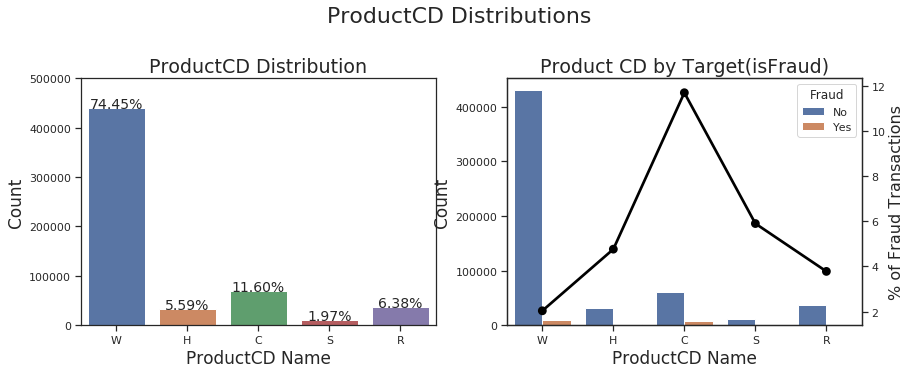

In [50]:
tmp = pd.crosstab(train_data['ProductCD'], train_data['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=train_data)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
total = len(train_data)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train_data)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

In the above proportion plot, the height of the brown(at the top) represents the probability of a transaction involving a given product category being fraudulent. We can see that a product of category C is more likely to be involved in a fraudulent transaction(as shown by percentage of fraudulent transactions) as compared to any other product category. The next most fraudulence-prone product category is category S, and so on.

**isFraud** vs **card4**


Text(0, 0.5, 'Count')

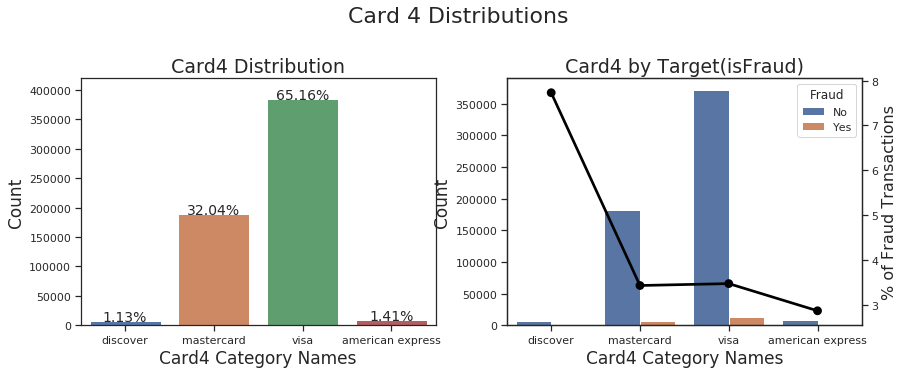

In [51]:
tmp = pd.crosstab(train_data['card4'], train_data['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=train_data)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=train_data)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

In the above proportion plot, the height of the dark orange bar represents the probability of a transaction received through a given card brand being fraudulent. We can see that discover cards are associated with the highest probability of a fraudulent transaction. The remaining card brands have a very similar fraudulence proportion. Thus, we can say that **Discover Cards** are most prone to fraudulence as compared to other card issuers although the number of transactions done using VISA is the most.

**isFraud** vs **card6**

Text(0, 0.5, 'Count')

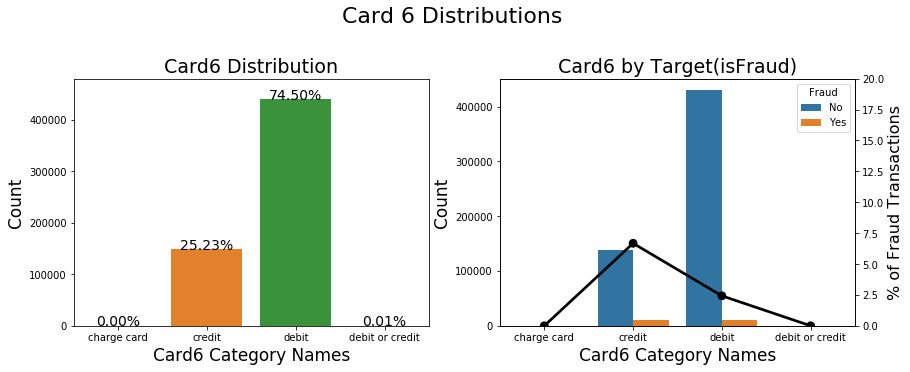

In [10]:
# filtered_data = train_data.query("card6 == 'credit' or card6 == 'debit'")
# pd.crosstab(filtered_data.isFraud,filtered_data.card6).plot(kind='bar')


# fig, ax = plt.subplots(figsize=(5, 5))
# props = filtered_data.groupby("card6")['isFraud'].value_counts(normalize=True).unstack()
# sns.set_palette(['plum', 'purple'])
# props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
# plt.show(plot)

tmp = pd.crosstab(train_data['card6'], train_data['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card6', data=train_data, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=train_data, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

It can be inferred from the graph that credit card is more prone to fraudulent transactions than the debit card despite of the fact that 74.5 % of the transactions are done through debit card.

**isFraud** vs **P_emaildomain (purchaser email)**

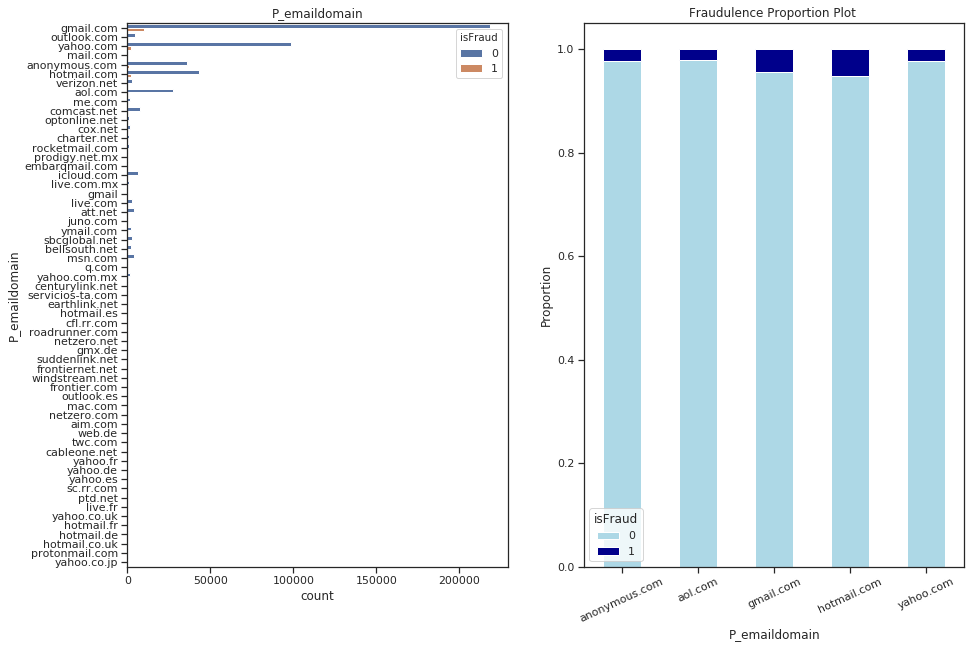

In [52]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
sns.countplot(y="P_emaildomain",hue="isFraud", ax=ax[0], data=train_data)
sns.set(style="ticks")
ax[0].set_title('P_emaildomain')

props = train_data.query("P_emaildomain in ['gmail.com', 'yahoo.com', 0.0, 'hotmail.com', 'anonymous.com', 'aol.com']")\
                .groupby("P_emaildomain")['isFraud'].value_counts(normalize=True).unstack()

sns.set_palette(['lightblue', 'darkblue'])

props.plot(kind='bar', stacked='True', ax=ax[1]).set_ylabel('Proportion')
ax[1].set_title('Fraudulence Proportion Plot ')
plt.xticks(rotation=25)
plt.show(plot)

In the above proportion plot, the height of the dark blue bar (at the top) represents the probability of a transaction made through a given email domain being fraudulent. We can see that an email domain of hotmail.com is associated with the highest probability of a fraudulent transaction. The next most fraudulence-prone email domain is gmail.com. And, the others have almost same proportion.

**isFraud** vs **R_emaildomain (recipient email)**

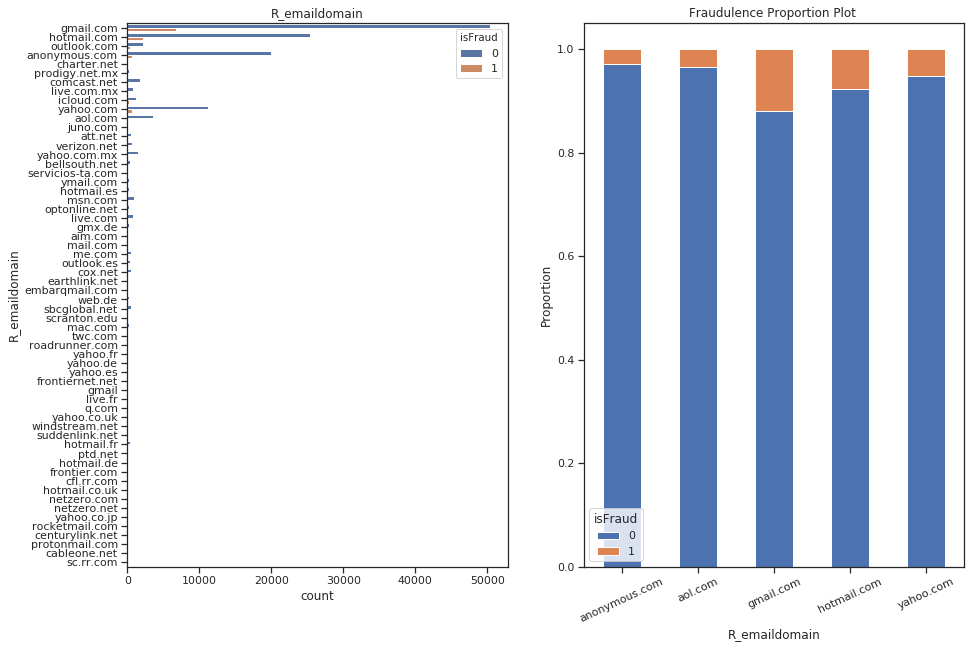

In [54]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
sns.countplot(y="R_emaildomain",hue="isFraud", ax=ax[0], data=train_data)
sns.set(style="ticks")
ax[0].set_title('R_emaildomain')

props = train_data.query("R_emaildomain in ['gmail.com', 'yahoo.com', 0.0, 'hotmail.com', 'anonymous.com', 'aol.com']")\
                .groupby("R_emaildomain")['isFraud'].value_counts(normalize=True).unstack()

# sns.set_palette(['lightblue', 'darkblue'])

props.plot(kind='bar', stacked='True', ax=ax[1]).set_ylabel('Proportion')
ax[1].set_title('Fraudulence Proportion Plot ')
plt.xticks(rotation=25)
plt.show(plot)

In the above proportion plot, the height of the brown bar (at the top) represents the probability of a transaction received through a given email domain being fraudulent. We can see that an email domain of gmail.com is associated with the highest probability of a fraudulent transaction. The next most fraudulence-prone email domain is hotmail.com. And, the least fraudulence-prone email domain is anonymous.com.

**addr1** and **addr2**

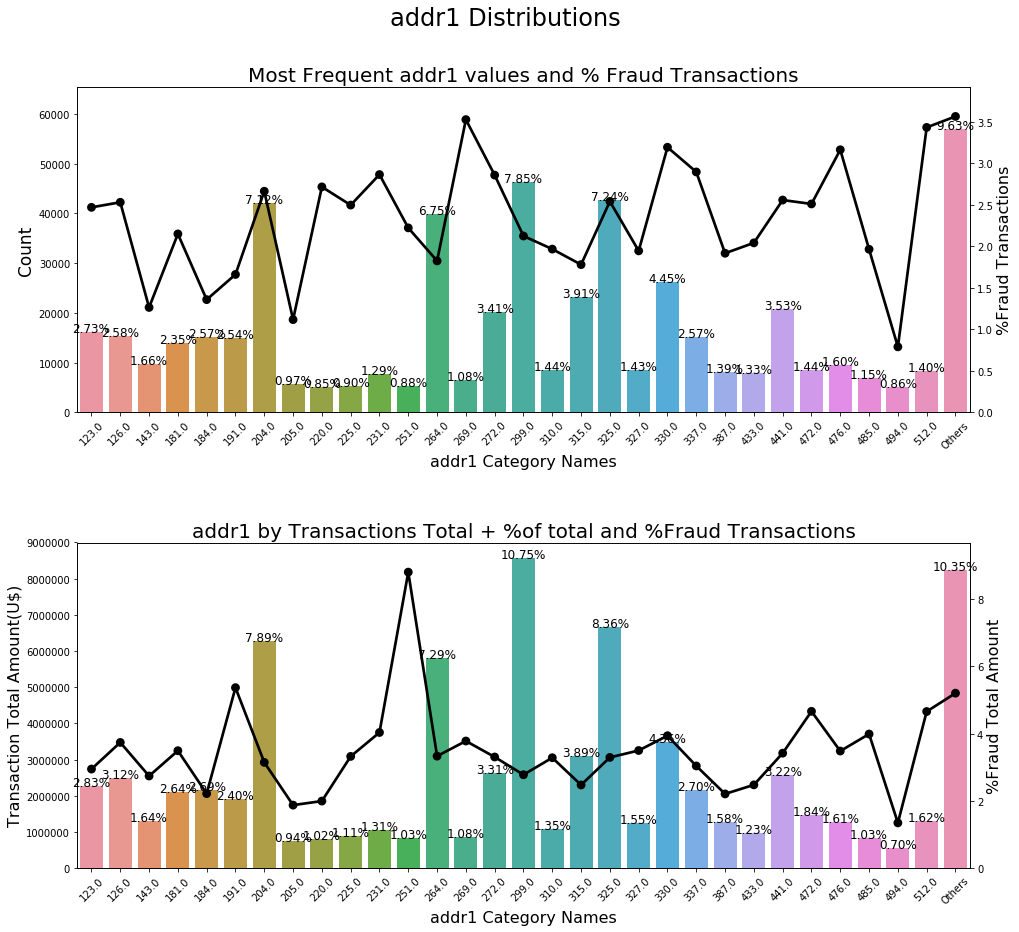

In [21]:
# fig,ax=plt.subplots(1,2,figsize=(15,8))
# sns.distplot(nonfraudulent_transactions['addr1'],ax=ax[0],hist=False,label='NonFraud')
# sns.distplot(fraudulent_transactions['addr1'],ax=ax[0],hist=False,label='Fraud')
# # ax[0].set_title('nonfraudulent_transactions addr1 Distribution')
# ax[0].set_title('transactions addr1 Distribution')


# sns.distplot(nonfraudulent_transactions['addr2'],ax=ax[1],hist=False,label='NonFraud')
# sns.distplot(fraudulent_transactions['addr2'],ax=ax[1],hist=False,label='Fraud')
# ax[1].set_title('transactions addr2 Distribution')



train_data.loc[train_data.addr1.isin(train_data.addr1.value_counts()[train_data.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
ploting_cnt_amt(train_data, 'addr1')


It can inferred from the above two graphs that the most no. of fraudulent transactions happen in the billing region 269 but the max sum of transactions which are fraudulent mostly occur in billing region 251. We can also see the no. of transactions is also more in others but the sum of transactions is much less for this category.

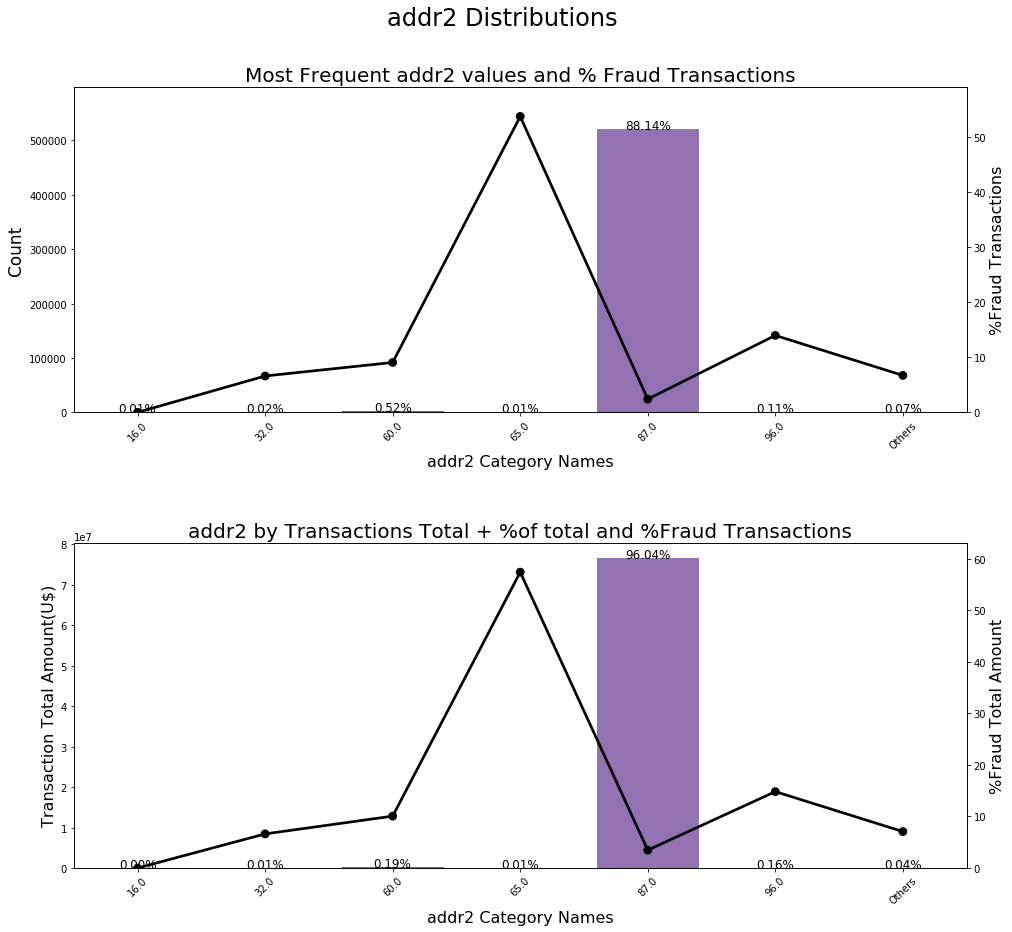

In [22]:
train_data.loc[train_data.addr2.isin(train_data.addr2.value_counts()[train_data.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"
ploting_cnt_amt(train_data, 'addr2')

most of transactions are happening in country code 87 while other country codes are having very less transactions. Thus, we can assume that the most of the transactions happened in the same time zone. 

**dist1** and **dist2**

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'fraudulent_transactions dist2 Distribution')

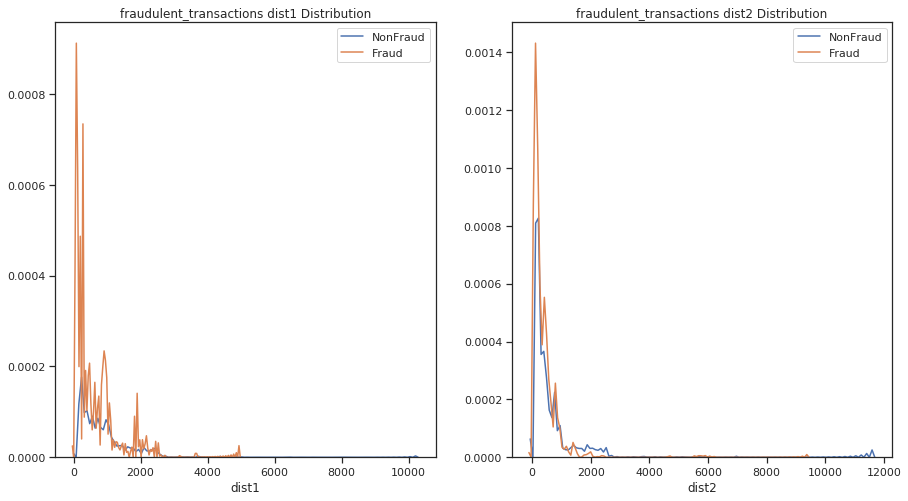

In [0]:
fig,ax=plt.subplots(1,2,figsize=(15,8))

sns.distplot(nonfraudulent_transactions['dist1'],ax=ax[0],hist=False,label='NonFraud')
sns.distplot(fraudulent_transactions['dist1'],ax=ax[0],hist=False,label='Fraud')
ax[0].set_title('nonfraudulent_transactions dist1 Distribution')
ax[0].set_title('fraudulent_transactions dist1 Distribution')


sns.distplot(nonfraudulent_transactions['dist2'],ax=ax[1],hist=False,label='NonFraud')
sns.distplot(fraudulent_transactions['dist2'],ax=ax[1],hist=False,label='Fraud')
ax[1].set_title('nonfraudulent_transactions dist2 Distribution')
ax[1].set_title('fraudulent_transactions dist2 Distribution')

For both dist1 and dist2, transactions are mostly occuring in 0 - 3000. It can be inferred that the values between 0-1000 of dist2 are more prone to fraudulent transactions.

## Part 2 - Transaction Frequency

520481


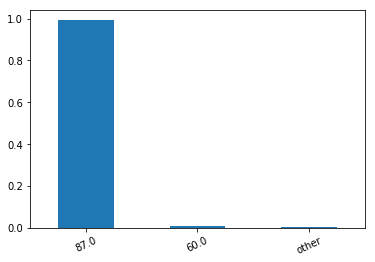

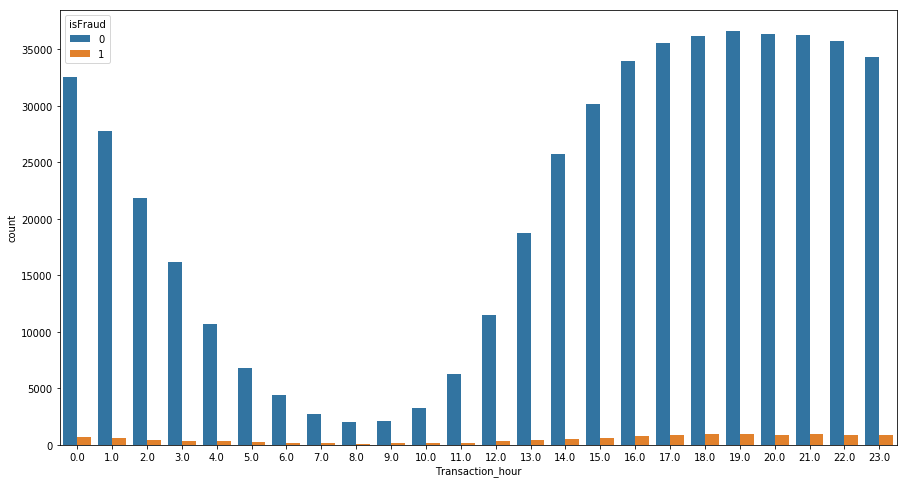

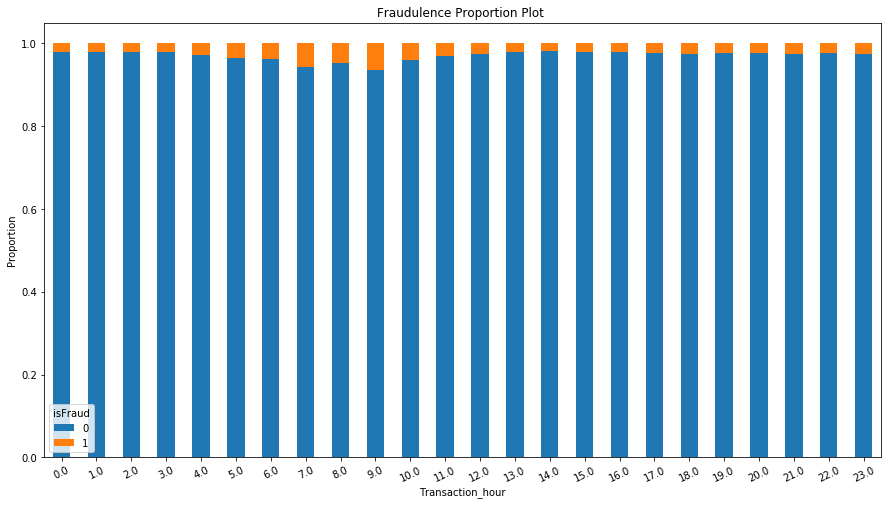

In [24]:
print(len(train_data.query("addr2 == 87")))
prob = train_data.addr2.value_counts(normalize=True)
threshold = 0.005
mask = prob > threshold
# print(mask)
tail_prob = prob.loc[~mask].sum()
# print(tail_prob)

prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar')
plt.xticks(rotation=25)
plt.show()

#most frequent country code is 87 and more than 90% transactions are done from country code 87 
# This can be inferred from the country code distribution below.

fig, ax = plt.subplots(figsize=(15,8))

ax = sns.countplot(x="Transaction_hour", hue="isFraud", data=train_data.query("addr2 == 87"))

props = train_data.query("addr2 == 87")\
                .groupby("Transaction_hour")['isFraud'].value_counts(normalize=True).unstack()
fig, ax = plt.subplots(figsize=(15,8))
props.plot(kind='bar', stacked='True', ax=ax).set_ylabel('Proportion')
ax.set_title('Fraudulence Proportion Plot ')
plt.xticks(rotation=25)

plt.show()

We can infer  from the transaction_hour distribution that the waking hours are from 0-5 and 13-23 hours of the day as most of the transactions are happening during these hours.As the least transactions are furing 6-12 hours, this duration corresponds to the sleeping hours.

---

From the fraudulence proportion plot, we can infer that most of the transactions by proportion, that happen from 6-10 hours of a day, are fraudulent. 

## Part 3 - Product Code

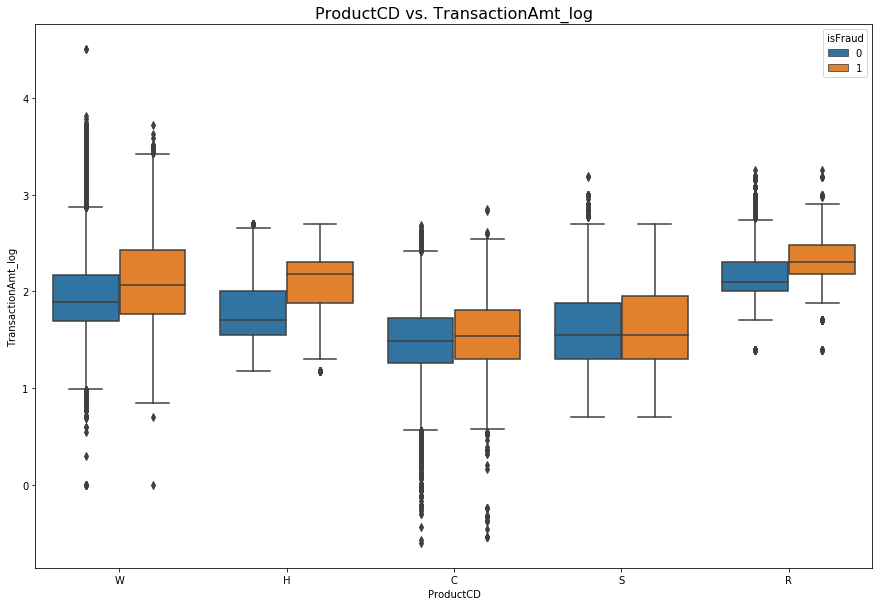

In [0]:
fig, ax = plt.subplots(figsize=(15, 10))

plot = sns.boxplot(x="ProductCD", y="TransactionAmt_log",hue="isFraud",
                   data=train_data,
                   ax=ax).set_title('ProductCD vs. TransactionAmt_log', fontsize=16)

plt.show(plot)

In [0]:
temp_data = train_data.groupby("ProductCD")

temp_data[["TransactionAmt"]].describe()

TransactionAmt                          ...                             
                   count        mean         std  ...      50%      75%        max
ProductCD                                         ...                             
C                68519.0   42.872353   38.943070  ...   31.191   54.102    712.896
H                33024.0   73.170058   61.950955  ...   50.000  100.000    500.000
R                37699.0  168.306188  142.035568  ...  125.000  200.000   1800.000
S                11628.0   60.269487   80.546775  ...   35.000   80.000   1550.000
W               439670.0  153.158554  268.733692  ...   78.500  146.000  31937.391

[5 rows x 8 columns]

The most expensive product is R as we can see from the graph that its median is the highest when compared to other products. Also, we can infer this from the above table as mean as well as median of product R is the highest.

The cheapest product is C as we can see from the box plot that median is the lowest as well as most of the product are having lower transaction amount. Also, it can be inferred from the above table that mean and median of product C is the lowest. 




## Part 4 - Correlation Coefficient

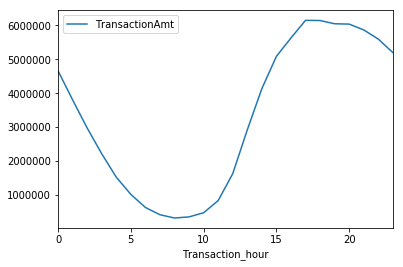

In [12]:
train_data.groupby('Transaction_hour').sum()[['TransactionAmt']].plot(legend=True)

The above graph indicates the trend of sum of transactions per transaction hourm of a day.

In [40]:
TransactionAmt_sum = train_data.groupby('Transaction_hour').sum()[['TransactionAmt']]
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20, 21, 22,23]
TransactionAmt_sum["Hours"] = hours
TransactionAmt_sum

,TransactionAmt,Hours
Transaction_hour,,
0.0,4.660496e+06,0
1.0,3.805385e+06,1
2.0,2.976132e+06,2
3.0,2.217529e+06,3
4.0,1.527839e+06,4
5.0,1.021160e+06,5
6.0,6.350526e+05,6
7.0,4.217264e+05,7
8.0,3.250133e+05,8


Spearmans correlation for fraudulent_transactions: 0.630
Pearsons correlation fraudulent_transactions : 0.642
Pearsons correlation nonfraudulent_transactions : 0.642


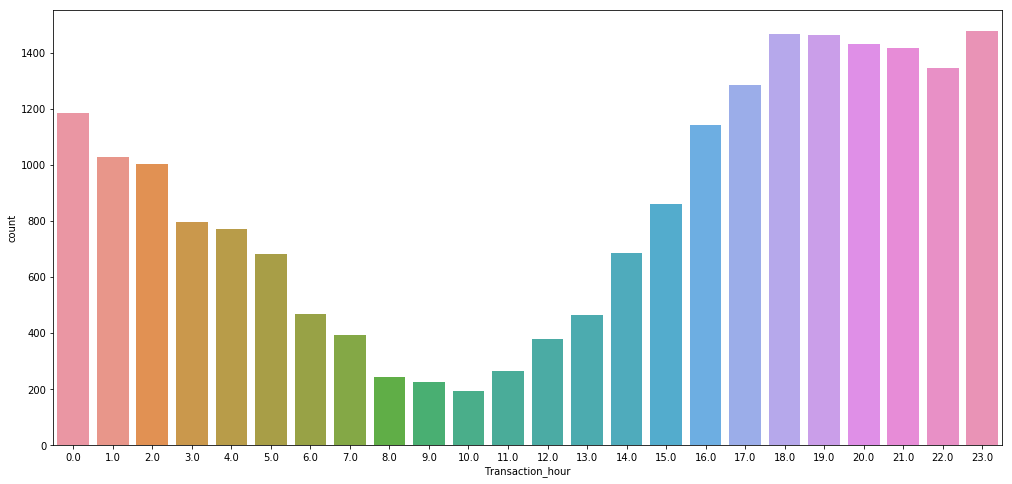

In [37]:
from scipy.stats import pearsonr, spearmanr

# calculate spearman's correlation
coef, p = spearmanr(TransactionAmt_sum['Hours'], TransactionAmt_sum['TransactionAmt'])
print('Spearmans correlation for sum of transaction amt and Transaction Hours: %.3f' % coef)

# calculate Pearson's correlation
corr, _ = pearsonr(TransactionAmt_sum['Hours'], TransactionAmt_sum['TransactionAmt'])
print('Pearsons correlation transactions : %.3f' % corr)

# corr, _ = pearsonr(TransactionAmt_sum['Hours'], TransactionAmt_sum['TransactionAmt'])
# print('Pearsons correlation nonfraudulent_transactions : %.3f' % corr)

# print('Correlation : %.3f' % fraudulent_transactions['Transaction_hour'].corr(fraudulent_transactions['TransactionAmt']))

fig, ax = plt.subplots(figsize=(17,8))

ax = sns.countplot(x="Transaction_hour", data=fraudulent_transactions)

# ax = sns.scatterplot(x="Transaction_hour", y="TransactionAmt_log", data=train_data)



Graph showing the distribution of fraudulent transactions as per transaction hours.

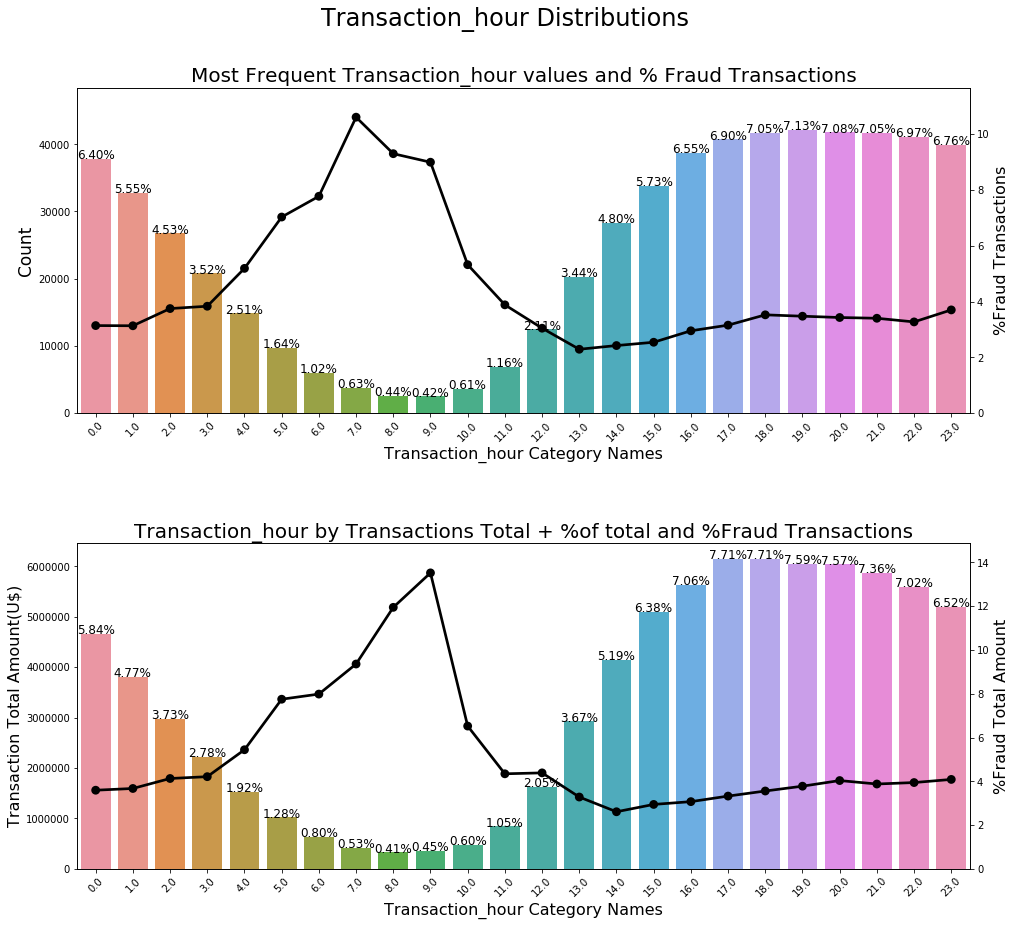

In [29]:
ploting_cnt_amt(train_data, 'Transaction_hour')

We can infer from the distribution of transaction hours and count that proportion of the fraudulent transactions happen mostlty during non waking hours although the transactions happening during this time is the least. Also, after analyzing the distribution of sum of Transaction_Amt vs transaction_hour, we can conclude that non waking hours are most prone to fraudulent transactions. 


## Part 5 - Interesting Plot

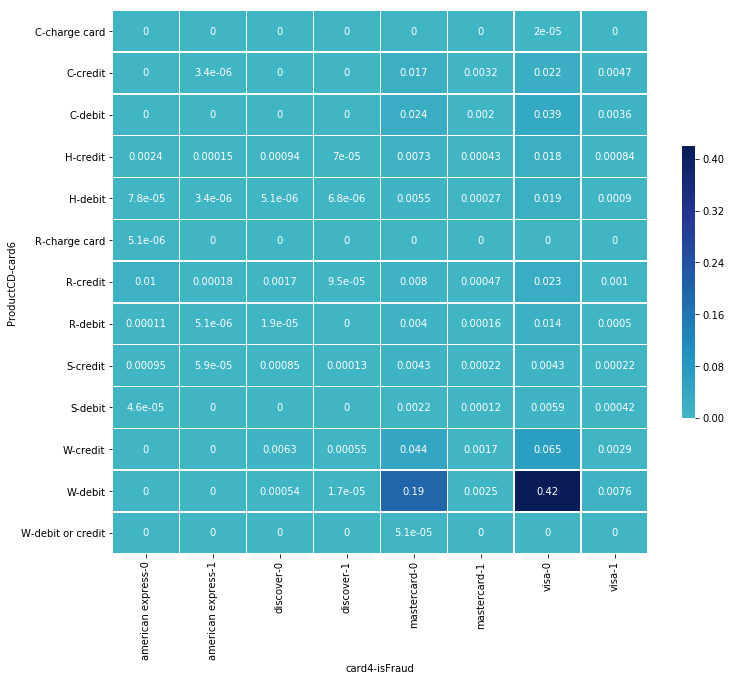

In [0]:
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab([train_data.ProductCD, train_data.card6],[train_data.card4,train_data.isFraud], 
     rownames=['ProductCD', 'card6'], 
      colnames=['card4', 'isFraud'], normalize=True),cmap="YlGnBu",linewidth=0.5 ,square=False,center=0, annot=True, cbar_kws={"shrink": .5})

ValueError: ignored

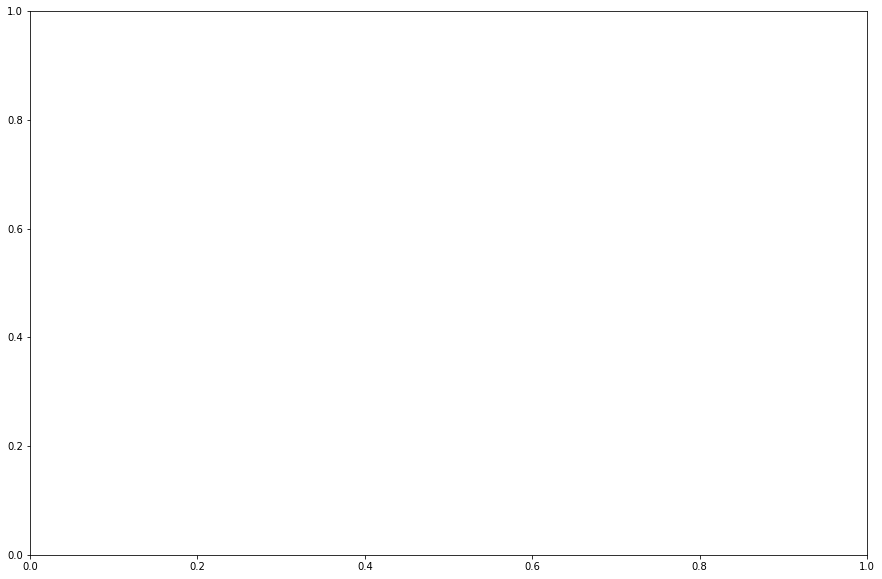

In [40]:
# TODO: code to generate the plot here.

fig, ax = plt.subplots(figsize=(15, 10))

plot = sns.violinplot(x="card6", y="TransactionAmt_log", hue="isFraud",scale="width",
                      data=train_data, palette=['mediumspringgreen', 'yellow'],
                      ax=ax).set_title('card6 vs. TransactionAmt_log', fontsize=16)

plt.show(plot)

In the above violin plots, the light green violin plot represent the distribution for non-fraudulent cases and the yellow violin plot represent the distribution for fraudulent cases. 

The non-fraudulent and fraudulent distributions are very similar for the C product category. Both the distributions have only one peak and they look very similar in almost every way. Interestingly, the C product category also has the highest fraudulence rate, and this is probably the reason why the correlation between the transaction amount and the target is very low for this category.

But, for the rest of the product categories, the trend is roughly followed.

The distributions for the S product category seem to have the lowest means and the strongest skews. These distributions have a very high concentration of probability density around the lower values of TransactionAmt. Transactions of type S tend to have low transaction amounts. On the other side of the spectrum, the distributions for the R product category seem to have the highest means and the weakest skews. These distributions have a very even spread and almost no skew. Transactions of type R tend to have high transaction amounts.

Write your answer here

## Part 6 - Prediction Model

In [0]:
## Categorical Features

def create_col_name(base_str, start_int, end_int):
    return [base_str + str(i) for i in range(start_int, end_int+1)]

categorical_features = (['ProductCD'] + create_col_name('card', 1, 6) + ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            create_col_name('M', 1, 9) + ['DeviceType', 'DeviceInfo'] + create_col_name('id_', 12, 38))
print(categorical_features)

['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [0]:
print("No Of NANs in dist1 : ", len(train_data) - train_data['dist1'].count())
print("No Of NANs in dist2 : ", len(train_data) - train_data['dist2'].count())
print("No Of NANs in addr1 : ", len(train_data) - train_data['addr1'].count())
print("No Of NANs in addr2 : ", len(train_data) - train_data['addr2'].count())

print("No Of NANs in DeviceType : ", len(train_data) - train_data['DeviceType'].count())
print("No Of NANs in DeviceInfo : ", len(train_data) - train_data['DeviceInfo'].count())
print("No Of NANs in TransactionDT : ", len(train_data) - train_data['TransactionDT'].count())
print("No Of NANs in TransactionAmt : ", len(train_data) - train_data['TransactionAmt'].count())


No Of NANs in dist1 :  352271
No Of NANs in dist2 :  552913
No Of NANs in addr1 :  65706
No Of NANs in addr2 :  65706
No Of NANs in DeviceType :  449730
No Of NANs in DeviceInfo :  471874
No Of NANs in TransactionDT :  0
No Of NANs in TransactionAmt :  0


In [0]:
# k significant features

# from sklearn.feature_selection import SelectKBest, chi2
# y_train = train['isFraud']
# X_train = train.drop(columns=['isFraud'])
# X_new = SelectKBest(chi2, k=50).fit_transform(X_train, y_train)
# X_new.shape

In [17]:
# remove insignificant features

one_value_cols_train = [col for col in train_data.columns if train_data[col].nunique() <= 1]  ## []
one_value_cols_test = [col for col in test_data.columns if test_data[col].nunique() <= 1]  ##['V107']

train_data_rows = train_data.shape[0]
test_data_rows = test_data.shape[0]

many_null_cols_train = [col for col in train_data.columns if train_data[col].isnull().sum() / train_data_rows > 0.9]
many_null_cols_test = [col for col in test_data.columns if test_data[col].isnull().sum() / test_data_rows > 0.9]

big_top_value_cols_train = [col for col in train_data.columns if train_data[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test_data.columns if test_data[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(one_value_cols_train + one_value_cols_test + many_null_cols_train + many_null_cols_test + big_top_value_cols_train + big_top_value_cols_test))

cols_to_drop.remove('isFraud')

print('{} features are going to be dropped'.format(len(cols_to_drop)))

print(cols_to_drop)

82 features are going to be dropped
['id_23', 'V281', 'V296', 'V319', 'V121', 'id_27', 'V125', 'id_21', 'V118', 'V309', 'V55', 'V290', 'V111', 'V123', 'V117', 'id_25', 'V134', 'id_18', 'V102', 'V321', 'V297', 'V24', 'V68', 'V110', 'V132', 'V23', 'V66', 'V104', 'dist2', 'V25', 'V67', 'V116', 'V120', 'V286', 'V298', 'id_26', 'V301', 'V320', 'V86', 'V88', 'V135', 'V129', 'C3', 'V65', 'V77', 'D7', 'V133', 'V109', 'V136', 'V295', 'V27', 'V89', 'V284', 'V137', 'V316', 'V14', 'V311', 'id_08', 'V106', 'V113', 'V114', 'V115', 'V122', 'V124', 'V305', 'V26', 'V107', 'V300', 'V299', 'V105', 'V101', 'V293', 'V318', 'id_24', 'V108', 'V98', 'V119', 'V28', 'id_22', 'V112', 'id_07', 'V103']


In [0]:
## Testing for missing drop columns
for col in cols_to_drop:
    if col not in train_data.columns:
        print("missing drop column in train",col)
    if col not in test_data.columns:
        print("Missing drop columns in test",col)

In [0]:
## Dropping useless Columns
cols_to_drop_in_train= cols_to_drop + ['Transaction_day_of_week','Transaction_hour', 'TransactionAmt_log']
train_data = train_data.drop(cols_to_drop_in_train, axis=1)
test_data = test_data.drop(cols_to_drop, axis=1)
# (590540, 434)
# (506691, 433)


In [20]:
print(train_data.shape)
print(test_data.shape)

(590540, 352)
(506691, 351)


In [21]:

##Convert categorical string data into numerical format

from sklearn import preprocessing

temp_train = train_data
temp_test = test_data

for f in temp_train.columns:
  if f not in cols_to_drop and f!='isFraud':
    if temp_train[f].dtype=='object' or temp_test[f].dtype=='object': 
      print("label encoding ",f)
      temp_train[f].fillna("NaN", inplace = True)
      temp_test[f].fillna("NaN", inplace = True)
      lbl = preprocessing.LabelEncoder()
      lbl.fit(list(temp_train[f].values) + list(temp_test[f].values))
      temp_train[f] = lbl.transform(list(temp_train[f].values))
      temp_test[f] = lbl.transform(list(temp_test[f].values))

train_df = temp_train
test_df = temp_test

# def prepare_data(df, cat_cols=cat_cols):
#     cat_cols = [col for col in cat_cols if col in df.columns]
#     for col in tqdm(cat_cols):\
#         df[col] = pd.factorize(df[col])[0]
#     return df

# train_df = prepare_data(temp_train)
# test_df = prepare_data(temp_test)


label encoding  ProductCD
label encoding  card4
label encoding  card6
label encoding  P_emaildomain
label encoding  R_emaildomain
label encoding  M1
label encoding  M2
label encoding  M3
label encoding  M4
label encoding  M5
label encoding  M6
label encoding  M7
label encoding  M8
label encoding  M9
label encoding  id_12
label encoding  id_15
label encoding  id_16
label encoding  id_28
label encoding  id_29
label encoding  id_30
label encoding  id_31
label encoding  id_33
label encoding  id_34
label encoding  id_35
label encoding  id_36
label encoding  id_37
label encoding  id_38
label encoding  DeviceType
label encoding  DeviceInfo


In [22]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
train = clean_inf_nan(train_df)
test = clean_inf_nan(test_df) 

for i in train.columns:
    train[i].fillna(train[i].median(),inplace=True) # filled with median because mean may be affected by outliers.

print(train.isna().sum().sum())

for i in test.columns:
    test[i].fillna(test[i].median(),inplace=True)
print(test.isna().sum().sum())



0
0


In [0]:
y_train = train['isFraud']
X_train = train.drop(columns=['isFraud'])
X_test = test

In [34]:
## Applying logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def get_score(model, X_train, X_test, y_train, y_test):
    %time model.fit(X_train, y_train)
    print(model.score(X_test, y_test))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    print("AUC : ", auc(false_positive_rate, true_positive_rate))
    print("roc_auc_score : ", roc_auc_score(y_test, model.predict(X_test)))
    print("f1 score : ",f1_score(y_test, model.predict_proba(X_test)[:,1], average="macro"))
    del X_train, X_test, y_train, y_test
    gc.collect()

logreg = LogisticRegression(solver ='lbfgs')

folds = StratifiedKFold(n_splits=5)

for train_index, test_index in folds.split(X_train,y_train):
    X1_train, y1_train = X_train.iloc[train_index], y_train.iloc[train_index]
    X1_test, y1_test = X_train.iloc[test_index], y_train.iloc[test_index]
    get_score(logreg, X1_train, X1_test, y1_train, y1_test)

# logreg.fit(X_train, y_train)


CPU times: user 26.3 s, sys: 5.85 s, total: 32.2 s
Wall time: 9.02 s
0.9650069004055576
AUC :  0.5136431276060325
roc_auc_score :  0.5


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 1min 21s, sys: 19.4 s, total: 1min 40s
Wall time: 26.3 s
0.9648375652998501
AUC :  0.6240616495454678
roc_auc_score :  0.501661121376409


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 1min 27s, sys: 20.4 s, total: 1min 47s
Wall time: 27.8 s
0.9645663291224981
AUC :  0.6403722742182808
roc_auc_score :  0.5002382420831121


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 1min 22s, sys: 19.5 s, total: 1min 42s
Wall time: 26.6 s
0.9649724402448627
AUC :  0.6085753847532417
roc_auc_score :  0.5002113050640553


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CPU times: user 1min 19s, sys: 19 s, total: 1min 38s
Wall time: 25.8 s
0.9542618134403549
AUC :  0.6429300149253193
roc_auc_score :  0.494428602763764


In [36]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score

folds = StratifiedKFold(n_splits=5)

score =0

def get_roc_auc_score(model, X_train, X_test, y_train, y_test):
    %time model.fit(X_train, y_train)
    print(model.score(X_test, y_test))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    print("AUC : ", auc(false_positive_rate, true_positive_rate))
    print("roc_auc_score : ", roc_auc_score(y_test, model.predict(X_test)))
    print("f1 score : ",f1_score(y_test, model.predict(X_test), average="macro"))
    del X_train, X_test, y_train, y_test
    gc.collect()


clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=2019,
    tree_method='gpu_hist'  
)
for train_index, test_index in folds.split(X_train,y_train):
    X1_train, y1_train = X_train.iloc[train_index], y_train.iloc[train_index]
    X1_test, y1_test = X_train.iloc[test_index], y_train.iloc[test_index]
    get_roc_auc_score(clf, X1_train, X1_test, y1_train, y1_test)

#  %time clf.fit(X_train, y_train)


CPU times: user 24.3 s, sys: 12.8 s, total: 37.1 s
Wall time: 37.2 s
0.9650746344478406
AUC :  0.8531469310988355
roc_auc_score :  0.5009678199854827
f1 score :  0.49304476391021856
CPU times: user 25.6 s, sys: 13 s, total: 38.7 s
Wall time: 38.6 s
0.9016755708709752
AUC :  0.8461308879218501
roc_auc_score :  0.7808148144015649
f1 score :  0.6318139901803763
CPU times: user 25.3 s, sys: 13.5 s, total: 38.8 s
Wall time: 38.8 s
0.9587157516848985
AUC :  0.8841117011590965
roc_auc_score :  0.7832035467768426
f1 score :  0.7402030632289951
CPU times: user 26.2 s, sys: 13.7 s, total: 39.9 s
Wall time: 39.9 s
0.970425122981703
AUC :  0.9405326198596141
roc_auc_score :  0.8095134503053119
f1 score :  0.7927901714840471
CPU times: user 25.3 s, sys: 13 s, total: 38.4 s
Wall time: 38.4 s
0.9715088860101433
AUC :  0.9244404247462602
roc_auc_score :  0.5981767105564624
f1 score :  0.6556166825148277


In [38]:
predictions_proba = clf.predict_proba(X_test)
# predictions = clf.predict(X_test)
# print(clf.score(X_test,y_test))
predictions_proba

array([[9.9964017e-01, 3.5985478e-04],
       [9.9982762e-01, 1.7238555e-04],
       [9.9959821e-01, 4.0177739e-04],
       ...,
       [9.9928135e-01, 7.1863458e-04],
       [9.9869907e-01, 1.3009247e-03],
       [9.9887300e-01, 1.1270075e-03]], dtype=float32)

In [0]:
submission = pd.read_csv('sample_submission.csv',index_col='TransactionID')
submission['isFraud'] = clf.predict_proba(X_test)[:,1]
submission.to_csv('xgboost_predictions_k_folds.csv')

In [0]:
p = logreg.predict(X_test)
p_prob = logreg.predict_proba(X_test)
p_prob

array([[0.96260166, 0.03739834],
       [0.9587927 , 0.0412073 ],
       [0.95642715, 0.04357285],
       ...,
       [0.95236125, 0.04763875],
       [0.95229629, 0.04770371],
       [0.78558111, 0.21441889]])

In [0]:
p_prob = p_prob[:, 1]
result = pd.Series(p_prob, index=X_test['TransactionID'], name='isFraud')
result.to_csv('Logreg_submission_Label_Encoding_80_perc.csv', header=True)
result.shape

(506691,)

In [0]:
submission = pd.read_csv('sample_submission.csv',index_col='TransactionID')
submission['isFraud'] = logreg.predict_proba(X_test)[:,1]
submission.to_csv('Logreg_submission.csv', header=True)
print(submission.shape)
submission.head()

(506691, 1)


,isFraud
TransactionID,
3663549,0.038910
3663550,0.039247
3663551,0.041492
3663552,0.039850
3663553,0.040491


Write your answer here

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: FILL HERE

Highest Rank: FILL HERE

*Score*: FILL HERE

[link text](https://)Number of entries: FILL HERE

INCLUDE IMAGE OF YOUR KAGGLE RANKING